In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../../Iquitos_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [3]:
nb_variables = {'window': 4, 'shift': -1}

In [4]:
print('------ Basic Stats about the Iquitos Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the Iquitos Training set ------ 

- Number of rows of the training set: 520 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.4% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [5]:
for col in df.columns[:-1]: # exclude the label variable
    df[col] = df[col].fillna(df.rolling(window = nb_variables['window'],
                                        min_periods = 1).mean()[col])
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print('- For the next step we will fill the remaining NAs with zeroes \n')

df = df.fillna(0)
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print(f'- We are ready to make predictions! \n')

- The amount of NAs was reduced to 0.11% 

- For the next step we will fill the remaining NAs with zeroes 

- The amount of NAs was reduced to 0.0% 

- We are ready to make predictions! 



# - Turn the problem into a supervised one
This is done by shifting the data to one or more steps into the future and using X, Y, X(t+1) variables to predict Y(t+1)

In [6]:
df_tp1 = df.shift(nb_variables['shift']).iloc[:nb_variables['shift'], :]

In [7]:
for i in range(len(df_tp1.columns)):
    df_tp1.rename(columns = {(df_tp1.columns[i]) : (df_tp1.columns[i] + '_tp1')}, inplace = True)

In [8]:
df_tp1

,year_tp1,weekofyear_tp1,ndvi_ne_tp1,ndvi_nw_tp1,ndvi_se_tp1,ndvi_sw_tp1,precipitation_amt_mm_tp1,reanalysis_air_temp_k_tp1,reanalysis_avg_temp_k_tp1,reanalysis_dew_point_temp_k_tp1,...,reanalysis_relative_humidity_percent_tp1,reanalysis_sat_precip_amt_mm_tp1,reanalysis_specific_humidity_g_per_kg_tp1,reanalysis_tdtr_k_tp1,station_avg_temp_c_tp1,station_diur_temp_rng_c_tp1,station_max_temp_c_tp1,station_min_temp_c_tp1,station_precip_mm_tp1,total_cases_tp1
week_start_date,,,,,,,,,,,,,,,,,,,,,
2000-07-01,2000.0,27.0,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0.0
2000-07-08,2000.0,28.0,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0.0
2000-07-15,2000.0,29.0,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0.0
2000-07-22,2000.0,30.0,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0.0
2000-07-29,2000.0,31.0,0.205529,0.190757,0.231671,0.255314,16.24,297.191429,298.285714,291.725714,...,74.728571,16.24,13.421429,13.771429,25.340000,10.940000,32.0,17.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-21,2010.0,21.0,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5.0
2010-05-28,2010.0,22.0,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8.0
2010-06-04,2010.0,23.0,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1.0


In [9]:
new_df = pd.concat([df.iloc[:-1, :], df_tp1], axis = 1)
new_df.index = pd.to_datetime(new_df.index)

In [10]:
new_df.shape

(519, 46)

## Important: we are dropping that variable because it's not available at the test set!

In [11]:
new_df.drop('total_cases', inplace = True, axis = 1)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
train_amount = 0.8
df_x_train = new_df.iloc[:int(train_amount * len(new_df)), : -1]
df_x_test = new_df.iloc[int(train_amount * len(new_df)):, : -1]

df_x_train = scaler.fit_transform(X = df_x_train)
df_x_test = scaler.transform(X = df_x_test)

df_y_train = new_df.iloc[:int(train_amount * len(new_df)), -1]
df_y_test = new_df.iloc[int(train_amount * len(new_df)):, -1]

- Save scaler to use it on test data

In [14]:
pickle.dump(scaler, open('../models/iq_scaler', "wb"))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [16]:
opt = Adam(learning_rate = 5e-5)

model = Sequential()
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = opt, loss='mae')

In [17]:
def lr_scheduler(epoch, lr):
    if epoch <= 40:
        return lr
    else:
        return lr * 0.98

In [18]:
# -- Checkpoints -- #
lr_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 75, restore_best_weights=True, mode = 'min')
checkpoint = ModelCheckpoint(monitor = 'val_loss', filepath = '../models/iq_mlp.keras', save_best_only = True, 
                             mode = 'min', save_freq = 'epoch')

In [19]:
history = model.fit(df_x_train, df_y_train, batch_size = 4, validation_data = (df_x_test, df_y_test), epochs=150, verbose=2,
                   use_multiprocessing = True, callbacks = [checkpoint, lr_scheduler])

Epoch 1/150


2023-01-27 17:57:53.099074: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


104/104 - 1s - loss: 7.3980 - val_loss: 9.4898 - lr: 5.0000e-05 - 1s/epoch - 10ms/step
Epoch 2/150
104/104 - 0s - loss: 7.3894 - val_loss: 9.4414 - lr: 5.0000e-05 - 179ms/epoch - 2ms/step
Epoch 3/150
104/104 - 0s - loss: 7.2130 - val_loss: 9.4919 - lr: 5.0000e-05 - 159ms/epoch - 2ms/step
Epoch 4/150
104/104 - 0s - loss: 7.1827 - val_loss: 9.4590 - lr: 5.0000e-05 - 155ms/epoch - 1ms/step
Epoch 5/150
104/104 - 0s - loss: 7.1358 - val_loss: 9.4633 - lr: 5.0000e-05 - 162ms/epoch - 2ms/step
Epoch 6/150
104/104 - 0s - loss: 7.1400 - val_loss: 9.4004 - lr: 5.0000e-05 - 176ms/epoch - 2ms/step
Epoch 7/150
104/104 - 0s - loss: 7.0814 - val_loss: 9.3489 - lr: 5.0000e-05 - 186ms/epoch - 2ms/step
Epoch 8/150
104/104 - 0s - loss: 7.0276 - val_loss: 9.3321 - lr: 5.0000e-05 - 179ms/epoch - 2ms/step
Epoch 9/150
104/104 - 0s - loss: 6.9759 - val_loss: 9.2358 - lr: 5.0000e-05 - 178ms/epoch - 2ms/step
Epoch 10/150
104/104 - 0s - loss: 6.9818 - val_loss: 9.1839 - lr: 5.0000e-05 - 184ms/epoch - 2ms/step
Epo

Epoch 82/150
104/104 - 0s - loss: 5.7784 - val_loss: 7.2589 - lr: 2.1839e-05 - 163ms/epoch - 2ms/step
Epoch 83/150
104/104 - 0s - loss: 5.8352 - val_loss: 7.2565 - lr: 2.1403e-05 - 159ms/epoch - 2ms/step
Epoch 84/150
104/104 - 0s - loss: 5.7147 - val_loss: 7.2146 - lr: 2.0974e-05 - 157ms/epoch - 2ms/step
Epoch 85/150
104/104 - 0s - loss: 5.7718 - val_loss: 7.2121 - lr: 2.0555e-05 - 157ms/epoch - 2ms/step
Epoch 86/150
104/104 - 0s - loss: 5.6676 - val_loss: 7.1998 - lr: 2.0144e-05 - 156ms/epoch - 1ms/step
Epoch 87/150
104/104 - 0s - loss: 5.6891 - val_loss: 7.1542 - lr: 1.9741e-05 - 178ms/epoch - 2ms/step
Epoch 88/150
104/104 - 0s - loss: 5.7116 - val_loss: 7.2074 - lr: 1.9346e-05 - 164ms/epoch - 2ms/step
Epoch 89/150
104/104 - 0s - loss: 5.5943 - val_loss: 7.2100 - lr: 1.8959e-05 - 161ms/epoch - 2ms/step
Epoch 90/150
104/104 - 0s - loss: 5.7454 - val_loss: 7.1694 - lr: 1.8580e-05 - 156ms/epoch - 1ms/step
Epoch 91/150
104/104 - 0s - loss: 5.6616 - val_loss: 7.1718 - lr: 1.8208e-05 - 156

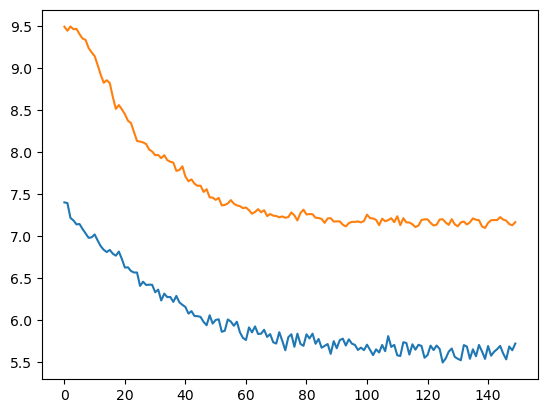

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [21]:
predictions = model.predict(df_x_test)
predictions = np.round(predictions).astype('int32')
predictions[predictions < 0] = 0
predictions.shape

4/4 [==============================] - 0s 1ms/step


(104, 1)

Train Dataset MAE: 7.391826923076923


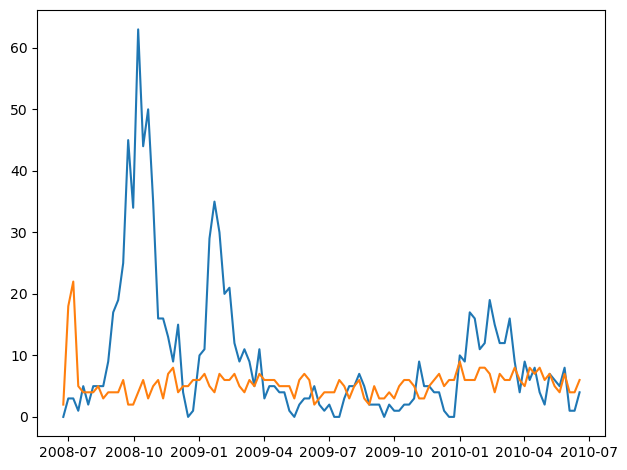

In [22]:
dataset_mae = np.mean(np.abs(predictions - df_y_test.values))
print(f'Train Dataset MAE: {dataset_mae}')
plt.plot(df_y_test);
plt.plot(df_y_test.index, predictions);
plt.tight_layout();